In [272]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
%load_ext autoreload
%autoreload 2
import model.dataset as ds
import model.models
import scipy.spatial.distance as ssdist
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import IPython.display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
torch.cuda.empty_cache()

### Loading the dataset

set up dataloader

In [268]:
path = '/usr0/home/tianjunm/datasets/processed/mixer/a1/train';
d = ds.SignalDataset(root_dir=path, transform=ds.Concat(size=(129, 690), encdec=True))
# d = ds.SignalDataset(root_dir=new, transform=ds.ToTensor(size=(129, 690)))

In [269]:
dataloader = torch.utils.data.DataLoader(d, batch_size=4, shuffle=False)

In [278]:
for i, info in enumerate(dataloader):
    aggregate = info['aggregate']
    ground_truths_in = info['ground_truths_in']
    ground_truths_gt = info['ground_truths_gt']
    
    break

_, seq_len, input_dim = aggregate.shape
print(aggregate.shape)
print(ground_truths_in.shape)
print(ground_truths_gt.shape)

torch.Size([4, 690, 258])
torch.Size([4, 691, 516])
torch.Size([4, 690, 2, 258])


In [285]:
def display(spect, sample_rate, y_axis='mel',x_axis='time'):
    db_data = librosa.power_to_db(np.abs(spect)**2, ref=np.max)
    librosa.display.specshow(db_data, sr=sample_rate, y_axis=y_axis, x_axis=x_axis)
    
def get_spect(data):
    r = np.split(data.numpy().T, 2)[0]
    i = np.split(data.numpy().T, 2)[1]
    c = r + 1j * i
    return c, scipy.signal.istft(c, fs=44100, nfft = 256)

visualize sample data

In [290]:
agg_sample = aggregate[0]
c_agg, (fs, data) = get_spect(agg_sample)

gt_1 = ground_truths_gt[0, :, 0, :]
gt_2 = ground_truths_gt[0, :, 1, :]
c_gt1, _ = get_spect(gt_1)
c_gt2, _ = get_spect(gt_2)

gin_1 = ground_truths_in.view(-1, seq_len+1, 2, input_dim)[0, :, 0, :]
gin_2 = ground_truths_in.view(-1, seq_len+1, 2, input_dim)[0, :, 1, :]
c_gin1, _ = get_spect(gin_1)
c_gin2, _ = get_spect(gin_2)

# print(np.array_equal())

In [307]:
# plt.subplot(2, 1, 1)
# plt.title('mixture audio wave')
# plt.plot(data)
# plt.axis('off')
# plt.subplot(2, 1, 2)
# plt.title('mixture spectrogram')
# plt.axis('off')
# display(c_agg, 22050*8)
# IPython.display.Audio(data=data, rate=44100)

True


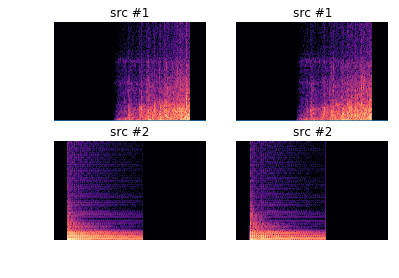

In [306]:
plt.subplot(2, 2, 1)
plt.title('src #1')
plt.plot(data)
plt.axis('off')
display(c_gin1, 22050*8)
plt.subplot(2, 2, 3)
plt.title('src #2')
plt.axis('off')
display(c_gin2, 22050*8)
plt.subplot(2, 2, 2)
plt.title('src #1')
plt.plot(data)
plt.axis('off')
display(c_gt1, 22050*8)
plt.subplot(2, 2, 4)
plt.title('src #2')
plt.axis('off')
display(c_gt2, 22050*8)

print(np.array_equal(gin_1[1:], gt_1))

In [217]:
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import IPython.display
import librosa
import librosa.display
import matplotlib.pyplot as plt

# _, rdata = scipy.signal.istft(c, fs=44100, nfft = 256)
# IPython.display.Audio(data=rdata, rate=44100)

transformer model

In [218]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [219]:
import model.transformer
_, seq_len, freq_range = aggregate.shape
print(seq_len)
print(freq_range)
net = model.transformer.make_model(freq_range).to(device)

690
258


In [220]:
from torch.autograd import Variable
subseq_mask = model.transformer.subsequent_mask(ground_truths_in.shape[1])
subseq_mask = Variable(subseq_mask).type_as(aggregate.data).to(device)

In [222]:
print(subseq_mask.shape)
# plt.figure(figsize=(5,5))
# plt.imshow(subseq_mask.cpu()[0])

torch.Size([1, 691, 691])


LSTM baselines

In [142]:
# print(aggregate.size())
# bs, seq_len, input_dim = aggregate.size()

# net = model.models.LookListen_Base(690, 129)

# net = model.models.B1(input_dim=input_dim, seq_len=seq_len, num_sources=3)
# net2 = model.models.B1(input_dim, seq_len=seq_len, num_sources=2)


# net.load_state_dict(torch.load('pretrained_range10/B1_checkpoint_euclidean_3_245.pth'))
# net.eval()


# net2.load_state_dict(torch.load('pretrained_range10/B1_checkpoint_euclidean_0_490.pth'))
# net2.eval()

In [262]:
# preds, _ = net(aggregate)
preds = net(aggregate.to(device), ground_truths_in.to(device), None, subseq_mask)
print(aggregate.shape)
print(preds.shape)
# preds2, _ = net2(aggregate)

torch.Size([4, 690, 258])
torch.Size([4, 691, 256])


In [263]:
preds = net.generator(preds)
preds.shape

torch.Size([4, 691, 516])

aggregate

In [31]:
_, data = scipy.signal.istft(c, fs=44100, nfft = 256)
IPython.display.Audio(data=data, rate=44100)

predicted separations

In [32]:
_, rdata = scipy.signal.istft(c1, fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [33]:
_, rdata = scipy.signal.istft(c2, fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [34]:
_, rdata = scipy.signal.istft(c3, fs=44100, nfft = 256)
IPython.display.Audio(data=rdata, rate=44100)

In [58]:
d = ds.SignalDataset(root_dir=new, transform=ds.ToTensor(size=(129, 690)))
dataloader = torch.utils.data.DataLoader(d, batch_size=32, shuffle=False)

Google look to listen baseline

In [59]:
for i, info in enumerate(dataloader):
#     print(i)
    aggregate = info['aggregate']
    ground_truths = info['ground_truths']
    break

In [62]:
bs, num_channels, seq_len, input_dim = aggregate.size()
net3 = model.models.LookListen_Base(input_dim=input_dim, seq_len=seq_len, num_sources=num_channels)

net3.load_state_dict(torch.load('pretrained_range10/google_checkpoint_euclidean_0_245.pth'))
net3.eval()

LookListen_Base(
  (convs): ModuleList(
    (0): Conv2d(2, 6, kernel_size=(1, 7), stride=(1, 1), padding=[0, 3])
    (1): Conv2d(6, 6, kernel_size=(7, 1), stride=(1, 1), padding=[3, 0])
    (2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2])
    (3): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[4, 4], dilation=(2, 2))
    (4): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[8, 8], dilation=(4, 4))
    (5): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[16, 16], dilation=(8, 8))
    (6): Conv2d(6, 8, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2])
  )
  (bns): ModuleList(
    (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2

In [63]:
preds3, _ = net3(aggregate)

testing model optimization

In [264]:
preds_cmp = preds.view(4, seq_len + 1, 2, 258)[:, :-1]
preds_cmp.shape

torch.Size([4, 690, 2, 258])

In [256]:
criterion = model.models.MinLoss(device, metric='euclidean')

In [265]:
loss = criterion(preds_cmp.to(device), ground_truths_gt.to(device))
loss

tensor(121476.1016, device='cuda:0', grad_fn=<DivBackward0>)

In [242]:
loss.backward()

In [243]:
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
optimizer.step()
# preds2 = net(aggregate)

In [244]:
seps = model.transformer.greedy_decoder(net, aggregate.to(device), seq_len, 2, freq_range, device)

In [245]:
pp = seps.view(1, seq_len + 1, 2, 258)

(0.0, 2.00562358276644, 0.0, 11025.0)

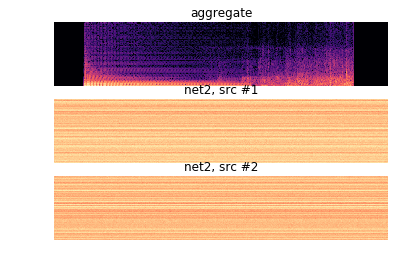

In [246]:
xid = 0
a = aggregate[0]
g1 = pp[xid, :, 0, :].cpu().numpy().T
g2 = pp[xid, :, 1, :].cpu().numpy().T

# g1 = aggregate[0].numpy().T
r1 = np.split(g1, 2)[0]
i1 = np.split(g1, 2)[1]

c1 = r1 + 1j * i1

r2 = np.split(g2, 2)[0]
i2 = np.split(g2, 2)[1]

c2 = r2 + 1j * i2

plt.subplot(3, 1, 1)
plt.title('aggregate')
display(c, 22050*8)
plt.axis('off')

plt.subplot(3, 1, 2)
plt.title('net2, src #1')
display(c1, 22050*8)
plt.axis('off')

plt.subplot(3, 1, 3)
plt.title('net2, src #2')
display(c2, 22050*8)
plt.axis('off')

random experiments

In [123]:
a = torch.arange(12).view(4, 3)
a1 = a[:2].view(-1, 3)
a2 = a[2:].view(-1, 3)

print(a1)
print(a2)

print(torch.cat([a1, a2]))
print(torch.cat([a1, a2]).shape)
# print(a.sha)

tensor([[0, 1, 2],
        [3, 4, 5]])
tensor([[ 6,  7,  8],
        [ 9, 10, 11]])
tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])
torch.Size([4, 3])


In [205]:
aa = torch.arange(12.).view(3, 4)
a = aa.view(4, 3)
# b = torch.ones(4, 3).copy_(a)
b = torch.cat([torch.ones(3).view(1,3), a])

print(aa)
print(a)
print(b)
aa.fill_(10)
print(a)
print(b)


tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]])
tensor([[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.]])
tensor([[ 1.,  1.,  1.],
        [ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.]])
tensor([[10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.]])
tensor([[ 1.,  1.,  1.],
        [ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.]])


In [178]:
torch.ones(2, 3)
torch.zeros(2, 3)

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [31]:

def check(m_c, m):
    for i in range(m_c.shape[0]):
        for j in range(m_c.shape[1]):
            batch = i // m.shape[1]
            ii = i % m.shape[1]
            assert(m_c[i][j] == m[batch][ii][j])
    print("passed")

check(agg_concat, agg)

passed
